Continuing on the Neighborhood Search stuff from yesterday, but using a simplified example "mesh"

In [101]:
import jax
import jax.numpy as jnp
import numpy as onp
import pyvista
import matplotlib.pyplot as plt
from functools import partial

Generate a simple cube.

In [102]:
spacing = 1
edge_size = 100
p = int(edge_size/spacing)
x = jnp.repeat(jnp.repeat(jnp.linspace(0,edge_size,p),p),p)
y = jnp.repeat(jnp.tile(jnp.linspace(0,edge_size,p),p),p)
z = jnp.tile(jnp.tile(jnp.linspace(0,edge_size,p),p),p)
xyz = jnp.stack([x,y,z],axis=1)
xyz_size = xyz.shape[0]
xyz_size

1000000

Plot point cloud.

In [103]:
# points = onp.array(xyz)
# pyvista.plot(
#     points,
#     render_points_as_spheres=True,
#     point_size=20,
#     show_scalar_bar=False,
# )

We need a hash function that converts from a 3D position to a 1D index. We also need a function that does the inverse, although it isn't a direct conversion since hash collisions are possible. That's the reason for the sorting and storage of an offset for each hash value.

In [104]:
@partial(jax.jit, static_argnames=["hash_map_size","spacing","prime_1","prime_2","prime_3"])
def xyz_to_hash(xyz_location:  jnp.array,
                hash_map_size: int,
                spacing:       float,
                prime_1 = 73856093,
                prime_2 = 19349663,
                prime_3 = 83492791
                ) -> jnp.array:
    '''
    Converts [N,3] array of xyz coordinates to an [N,] array of hash keys
    '''
    primes = jnp.array([prime_1,prime_2,prime_3])
    alpha = jnp.floor(xyz_location/spacing).astype(int)*primes[None,:]
    beta = jnp.bitwise_xor(jnp.bitwise_xor(alpha[:,0],alpha[:,1]),alpha[:,2])
    hash_keys = jnp.mod(beta,hash_map_size)
    return hash_keys

@partial(jax.jit, static_argnames=["hash_map_size"])
def process_hash(hash_keys:     jnp.array,
                 hash_map_size: int):
    sorted_indices = jnp.argsort(hash_keys)
    sorted_hash_keys = hash_keys[sorted_indices]
    counts = jnp.bincount(sorted_hash_keys, length=hash_map_size)
    offsets = jnp.cumsum(counts) - counts
    return [sorted_indices, sorted_hash_keys, counts, offsets]

@jax.jit
def hash_to_count(hash:   int,
                  counts: jnp.array):
    count = counts[hash]
    return count

@jax.jit
def hash_to_xyz(hash:           int,
                increment:      int,
                xyz:            jnp.array,
                sorted_indices: jnp.array,
                offsets:        jnp.array):
    xyz_location = xyz[sorted_indices[offsets[hash] + increment]]
    return xyz_location

In [105]:
hash_map_size = xyz_size*2
hash_spacing = 2*spacing
hash_keys = xyz_to_hash(xyz,hash_map_size,hash_spacing)
sorted_indices, sorted_hash_keys, counts, offsets = process_hash(hash_keys, hash_map_size)

To do the actual kernel calculations, we need the neighbors in a box around the main point of interest.

In [106]:
o = jnp.array([-hash_spacing,0,hash_spacing])
o_x = jnp.repeat(jnp.repeat(o,3),3)
o_y = jnp.repeat(jnp.tile(o,3),3)
o_z = jnp.tile(jnp.tile(o,3),3)
o_xyz = jnp.stack([o_x,o_y,o_z],axis=1)

In [107]:
@jax.jit
def increment_distance_inner(i,inner_carry):
    distance, center_xyz, xyz, hash, sorted_indices, offsets = inner_carry
    other_xyz = hash_to_xyz(hash, i, xyz, sorted_indices, offsets)
    distance = distance + jnp.sqrt(jnp.sum(jnp.square(center_xyz - other_xyz)))
    inner_carry = (distance, center_xyz, xyz, hash, sorted_indices, offsets)
    return inner_carry

@jax.jit
def increment_distance_outer(i,outer_carry):
    distance, center_xyz, xyz, hashes, counts, sorted_indices = outer_carry
    hash = hashes[i]
    count = counts[i]
    inner_carry = (distance, center_xyz, xyz, hash, sorted_indices, offsets)
    distance = jax.lax.fori_loop(0, count, increment_distance_inner, inner_carry)[0]
    outer_carry = (distance, center_xyz, xyz, hashes, counts, sorted_indices)
    return outer_carry

@jax.jit
def index_to_dist(index,xyz,o_xyz,hash_map_size,hash_spacing,sorted_indices,counts):
    center_xyz = xyz[index,:]
    hashes = xyz_to_hash(center_xyz+o_xyz, hash_map_size, hash_spacing)
    outer_carry = (0, center_xyz, xyz, hashes, counts, sorted_indices)
    return jax.lax.fori_loop(0, 27, increment_distance_outer, outer_carry)[0]

Note from the next day: the above is not correct 😔

Need to fix the counts

In [108]:
index_to_dist(1234,xyz,o_xyz,hash_map_size,hash_spacing,sorted_indices,counts)

Array(1622.2957, dtype=float32)

In [109]:
index_to_dist_v = jax.vmap(index_to_dist,in_axes=(0,None,None,None,None,None,None))

In [110]:
d_tot = index_to_dist_v(jnp.arange(0,xyz_size),xyz,o_xyz,hash_map_size,spacing,sorted_indices,counts)

OK this code seems to be working decently fast, at least for up to the 125k points I have tried. And that is for not just the neighborhood construction but also the evaluation. It seems that I will need to press all the kernel evaluation stuff into those three functions. 

Now we need to implement a kernel function of some sort. It should take in the distance between the point of interest and a target point, as well as the smoothing length. From Monaghan's 2005 paper (page 9):

In [111]:
@jax.jit
def kernel(distance, smoothing_length):
    q = distance/smoothing_length
    M = jnp.piecewise(q,[q<2,q<1],[(2-q)**3, (2-q)**3 - 4*(1-q)**3, 0])
    return (1/(4*jnp.pi))*M

kernel_v = jax.vmap(kernel,in_axes=(0,None))

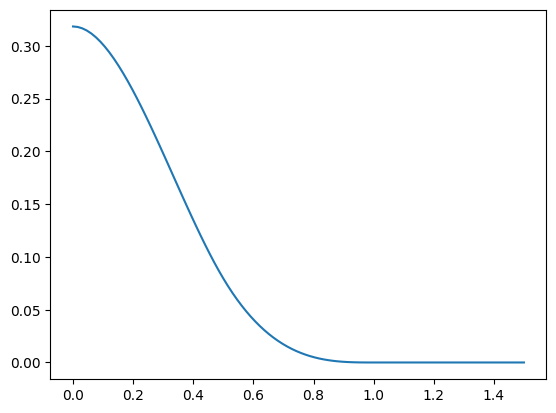

In [112]:
x = jnp.linspace(0,1.5,100)
y = kernel_v(x,0.5)
plt.plot(x,y)